In [3]:
from m8r import view

In [4]:
%%file 1_mtrain.scons 


import pandas as pd
import numpy as np
from sklearn import linear_model
import pickle
import m8r

# download data

Fetch('Data3_1_2020.zip','master',
      server='https://github.com',
      top='pddasig/Machine-Learning-Competition-2020/raw/')

Command('train.csv','Data3_1_2020.zip','unzip $SOURCE $TARGET')

Flow('train','train.csv','csv2rsf header=y')

# Remove missing values, despike
Flow('mask','train',
     'mask min=-998 | dd type=float | stack axis=1 prod=y | dd type=int')
Flow('mtrain','train mask',
     'headerwindow mask=${SOURCES[1]} | transp | despike wide=25')
Flow('labels.par','train',
     "grep key | sed s/key.=// | tr '\\n' ':' | sed s/^/labels=/")
Result('mtrain','mtrain labels.par',
       'dots transp=y gainpanel=each par=${SOURCES[1]} label1=')

Overwriting 1_mtrain.scons


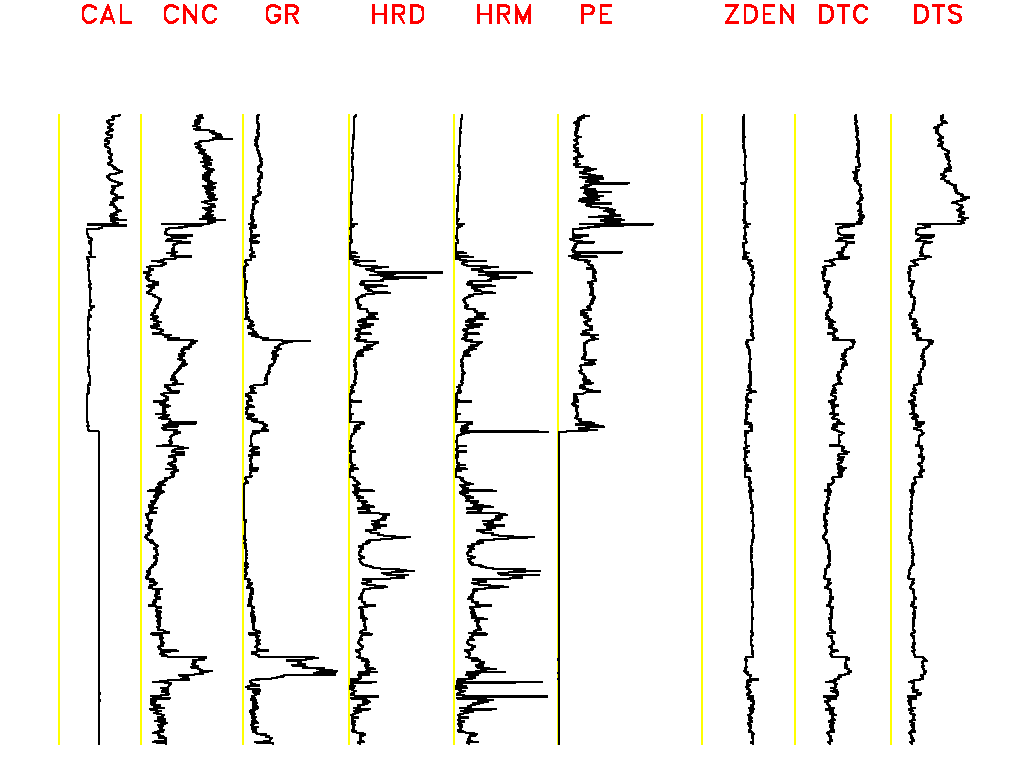

In [5]:
view("mtrain")

In [4]:
%%file 2_train2.scons 


def preprocess(target=None,source=None,env=None):
    logs = pd.read_csv(str(source[0]))
    # select two logs 
    two = logs.loc[:,['ZDEN','DTC']]
    # replace -999 with NaN
    two.replace(-999, np.nan, inplace=True)
    # drop rows with NaN
    two.dropna(inplace=True)
    two2=two.loc[(two.ZDEN > 1.5) & (two.ZDEN < 3.1)]
    np.random.seed(2021)
    split = env.get('split',0.9)
    select = np.random.rand(len(two2)) < split
    train = two2[select]
    test = two2[~select]
    train.to_csv(str(target[0]))
    test.to_csv(str(target[1]))   
                       
Command(['train2.csv','test2.csv'],'train.csv',
        action=Action(preprocess,varlist=['split']),
        split=0.8)

Flow('train2','train2.csv','csv2rsf header=y')
Result('train2',
       '''
       window f1=1 | dd type=complex | 
       window | graph symbol=x title="Training Data"
       label1=Density unit1="g/cm\\^3\\_"
       label2=Slowness unit2=ns/ft
       ''')

Writing 2_train2.scons


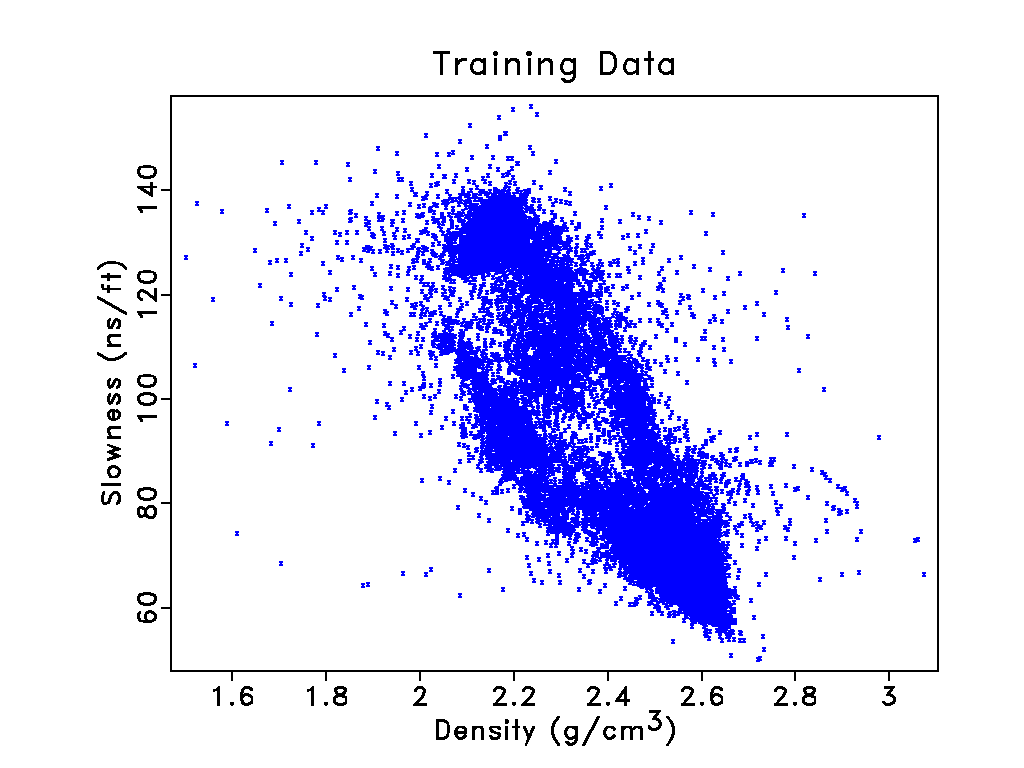

In [5]:
view("train2")

In [7]:
%%file 3_pred.scons 


def train(target=None,source=None,env=None):
    logs = pd.read_csv(str(source[0]))
    # use linear regression
    model = linear_model.LinearRegression()
    # train model
    model.fit(logs[['ZDEN']],logs['DTC'])
    # save model
    with open(str(target[0]),'wb') as dump:
        pickle.dump(model,dump)

Command('model.pickle','train2.csv',action=Action(train))

def predict(target=None,source=None,env=None):
    # load model
    with open(str(source[0]),'rb') as dump:
        model = pickle.load(dump)
    logs = pd.read_csv(str(source[1]))
    pred = model.predict(logs[['ZDEN']])
    rsf = m8r.File(pred,name=str(target[0]))

Command('pred.rsf',['model.pickle','test2.csv'],action=Action(predict))

Flow('test2','test2.csv','csv2rsf header=y')

Result('pred','test2 pred',
       '''
       window n1=1 f1=2 | cmplx ${SOURCES[1]} | 
       graph screenratio=1 title=Prediction symbol=x
       label1=Actual label2=Predicted unit1=ns/ft unit2=ns/ft
       ''')

Overwriting 3_pred.scons


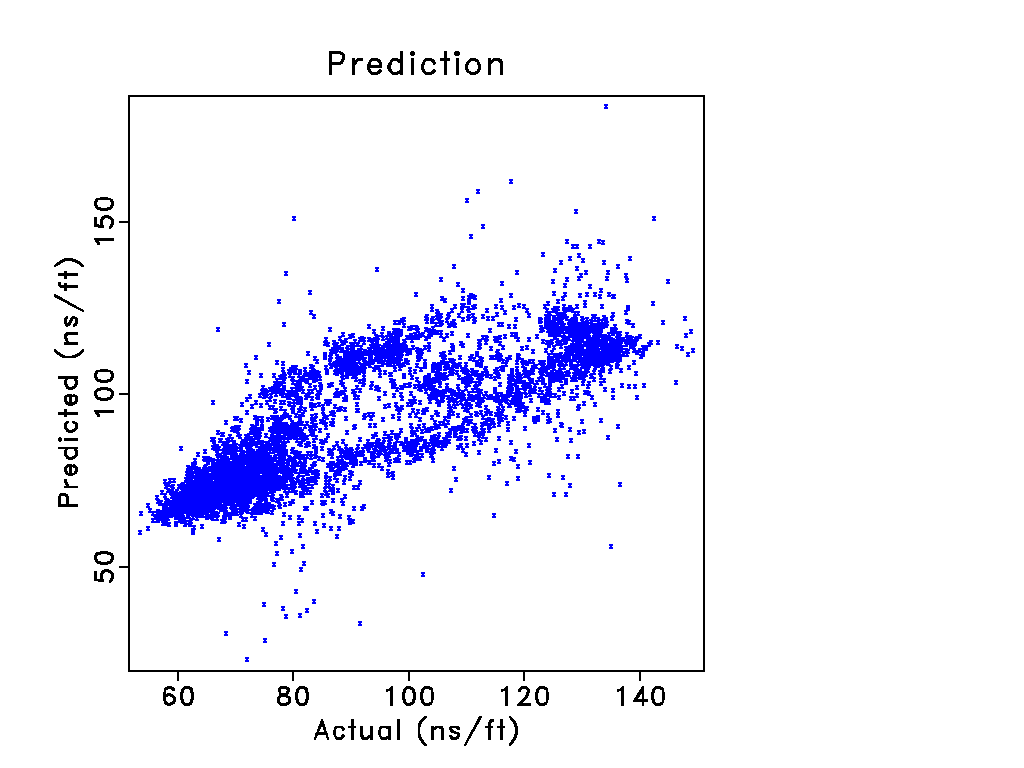

In [8]:
view("pred")